In [3]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [5]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/rajibdasbhagat/02-insurance-linear-regression


'https://jovian.ai/rajibdasbhagat/02-insurance-linear-regression'

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [6]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [7]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [8]:
your_name = "Rajib"

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [9]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [10]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
457,57,female,29.58015,0,no,12551.221553
1050,44,female,35.84635,1,no,8504.523577
56,58,female,30.87025,2,no,14423.810875
311,19,female,23.95900,0,no,1841.618560
1288,20,male,38.21800,2,yes,40645.239960


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [13]:
num_rows = dataframe.shape[0]
print("The dataset contains {} rows.".format(num_rows))

The dataset contains 1271 rows.


**Q: How many columns does the dataset have**

In [14]:
num_cols = dataframe.shape[1]
print("The dataset contains {} columns.".format(num_cols))

The dataset contains 6 columns.


**Q: What are the column titles of the input variables?**

In [17]:
input_cols = list(dataframe.columns[:-1])
print("The columns titles of input variables are: ")
for cols in input_cols:
     print(cols) 

The columns titles of input variables are: 
age
sex
bmi
children
smoker


**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [19]:
categorical_cols = list(dataframe.select_dtypes(include=['object']).columns)
print("The input columns which are non-numeric or categorial variables are: ")
for cols in categorical_cols:
     print(cols) 

The input columns which are non-numeric or categorial variables are: 
sex
smoker


**Q: What are the column titles of output/target variable(s)?**

In [22]:
output_cols = list(dataframe.columns[-1:])
print("The column titles of output/target variable(s) are: ")
for cols in output_cols:
     print(cols) 

The column titles of output/target variable(s) are: 
charges


**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

In [25]:
# Write your answer here

minimum = round(dataframe.charges.min(),3)
maximum = round(dataframe.charges.max(),3)
average = round(dataframe.charges.mean(),3)

print("The minimum, maximum, average value of the column charges are {}, {} and {} respectively." . format(minimum,maximum,average))

The minimum, maximum, average value of the column charges are 1189.186, 67596.654 and 13908.244 respectively.


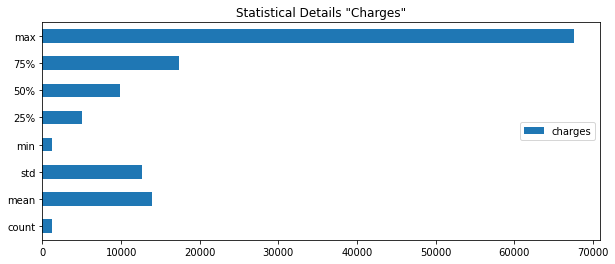

In [29]:
#statistical details of the dataframe.charges
desc=dataframe.charges.describe()

#plotting the statistical details
desc.plot.barh(figsize=(10,4))
plt.title("Statistical Details \"Charges\"")
plt.legend(loc='center right', frameon=True)

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [31]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [33]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[57.     ,  0.     , 29.58015,  0.     ,  0.     ],
        [44.     ,  0.     , 35.84635,  1.     ,  0.     ],
        [58.     ,  0.     , 30.87025,  2.     ,  0.     ],
        ...,
        [59.     ,  0.     , 33.756  ,  2.     ,  0.     ],
        [41.     ,  1.     , 27.936  ,  1.     ,  0.     ],
        [36.     ,  0.     , 29.1194 ,  0.     ,  0.     ]]),
 array([[12551.221553 ],
        [ 8504.523577 ],
        [14423.810875 ],
        ...,
        [39125.2445118],
        [ 6659.1691   ],
        [ 5588.506348 ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [34]:
inputs  = torch.tensor(inputs_array).type(torch.float32)
targets = torch.tensor(targets_array).type(torch.float32)

In [35]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [36]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [94]:
val_percent = 0.1 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

train_ds, val_ds = random_split(dataset, (train_size,val_size)) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [95]:
batch_size = 8

In [96]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [97]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[19.0000,  1.0000, 33.8530,  0.0000,  1.0000],
        [54.0000,  1.0000, 29.1194,  0.0000,  0.0000],
        [35.0000,  0.0000, 42.0398,  2.0000,  0.0000],
        [37.0000,  0.0000, 33.7560,  2.0000,  1.0000],
        [54.0000,  0.0000, 29.8760,  3.0000,  0.0000],
        [24.0000,  1.0000, 22.9454,  0.0000,  0.0000],
        [52.0000,  0.0000, 36.2780,  0.0000,  0.0000],
        [18.0000,  0.0000, 32.8636,  0.0000,  0.0000]])
targets: tensor([[36918.3750],
        [25945.0664],
        [ 6197.7324],
        [42226.7109],
        [12831.6396],
        [ 2494.1465],
        [10212.6104],
        [12171.5928]])


## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [98]:
input_size = len(input_cols)
output_size = len(output_cols)

input_size, output_size

(5, 1)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [99]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                 # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = nn.functional.l1_loss(out, targets)                         # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = nn.functional.l1_loss(out, targets)                          # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [100]:
model = InsuranceModel()
model

InsuranceModel(
  (linear): Linear(in_features=5, out_features=1, bias=True)
)

Let's check out the weights and biases of the model using `model.parameters`.

In [102]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.3136, -0.3284, -0.1240, -0.0889,  0.2360]], requires_grad=True),
 Parameter containing:
 tensor([-0.4470], requires_grad=True)]

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [103]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [104]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 13584.779296875}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [105]:
epochs = 10
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)
history1

Epoch [10], val_loss: 6796.3291


[{'val_loss': 10201.50390625},
 {'val_loss': 7958.2705078125},
 {'val_loss': 7066.74267578125},
 {'val_loss': 6907.75732421875},
 {'val_loss': 6880.62158203125},
 {'val_loss': 6861.1630859375},
 {'val_loss': 6844.5126953125},
 {'val_loss': 6828.326171875},
 {'val_loss': 6811.70068359375},
 {'val_loss': 6796.3291015625}]

Text(0.5, 1.0, 'Val_loss vs. epochs')

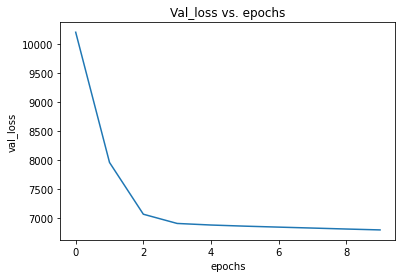

In [106]:
loss1 = []
for value in history1:
    loss1.append(value['val_loss'])
plt.plot(loss1)
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.title('Val_loss vs. epochs')

In [107]:
epochs = 100
lr = 1e-3
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6762.8838
Epoch [40], val_loss: 6728.0771
Epoch [60], val_loss: 6696.9663
Epoch [80], val_loss: 6666.6221
Epoch [100], val_loss: 6636.8779


Text(0.5, 1.0, 'Val_loss vs. epochs')

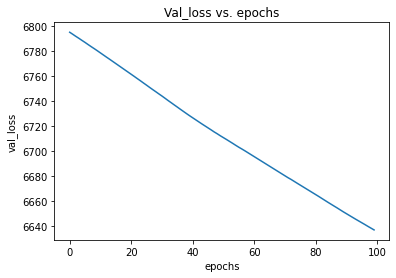

In [108]:
loss2 = []
for value in history2:
    loss2.append(value['val_loss'])
plt.plot(loss2)
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.title('Val_loss vs. epochs')

In [109]:
epochs = 500
lr = 1e-4
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6634.0327
Epoch [40], val_loss: 6631.1880
Epoch [60], val_loss: 6628.3247
Epoch [80], val_loss: 6625.3232
Epoch [100], val_loss: 6622.3091
Epoch [120], val_loss: 6619.2954
Epoch [140], val_loss: 6616.2812
Epoch [160], val_loss: 6613.2998
Epoch [180], val_loss: 6610.3779
Epoch [200], val_loss: 6607.4556
Epoch [220], val_loss: 6604.5337
Epoch [240], val_loss: 6601.6123
Epoch [260], val_loss: 6598.6704
Epoch [280], val_loss: 6595.6826
Epoch [300], val_loss: 6592.7046
Epoch [320], val_loss: 6589.7808
Epoch [340], val_loss: 6586.8794
Epoch [360], val_loss: 6583.9883
Epoch [380], val_loss: 6581.0884
Epoch [400], val_loss: 6578.1665
Epoch [420], val_loss: 6575.2285
Epoch [440], val_loss: 6572.2871
Epoch [460], val_loss: 6569.3335
Epoch [480], val_loss: 6566.3877
Epoch [500], val_loss: 6563.4961


Text(0.5, 1.0, 'Val_loss vs. epochs')

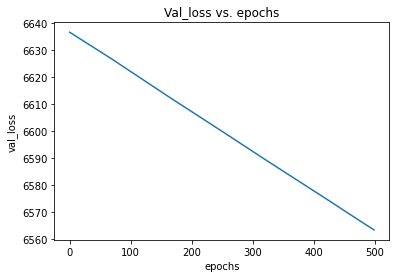

In [110]:
loss3 = []
for value in history3:
    loss3.append(value['val_loss'])
plt.plot(loss3)
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.title('Val_loss vs. epochs')

In [111]:
epochs = 800
lr = 1e-5
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6563.2080
Epoch [40], val_loss: 6562.9199
Epoch [60], val_loss: 6562.6323
Epoch [80], val_loss: 6562.3438
Epoch [100], val_loss: 6562.0557
Epoch [120], val_loss: 6561.7666
Epoch [140], val_loss: 6561.4790
Epoch [160], val_loss: 6561.1904
Epoch [180], val_loss: 6560.9019
Epoch [200], val_loss: 6560.6235
Epoch [220], val_loss: 6560.3398
Epoch [240], val_loss: 6560.0542
Epoch [260], val_loss: 6559.7637
Epoch [280], val_loss: 6559.4722
Epoch [300], val_loss: 6559.1797
Epoch [320], val_loss: 6558.8872
Epoch [340], val_loss: 6558.5952
Epoch [360], val_loss: 6558.3037
Epoch [380], val_loss: 6558.0107
Epoch [400], val_loss: 6557.7222
Epoch [420], val_loss: 6557.4419
Epoch [440], val_loss: 6557.1621
Epoch [460], val_loss: 6556.8828
Epoch [480], val_loss: 6556.6021
Epoch [500], val_loss: 6556.3228
Epoch [520], val_loss: 6556.0439
Epoch [540], val_loss: 6555.7578
Epoch [560], val_loss: 6555.4697
Epoch [580], val_loss: 6555.1812
Epoch [600], val_loss: 6554.8936
Epoch [620], v

Text(0.5, 1.0, 'Val_loss vs. epochs')

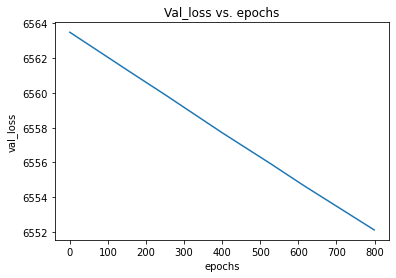

In [112]:
loss4 = []
for value in history4:
    loss4.append(value['val_loss'])
plt.plot(loss4)
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.title('Val_loss vs. epochs')

In [113]:
epochs = 1000
lr = 1e-6
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6552.0996
Epoch [40], val_loss: 6552.0718
Epoch [60], val_loss: 6552.0439
Epoch [80], val_loss: 6552.0161
Epoch [100], val_loss: 6551.9888
Epoch [120], val_loss: 6551.9609
Epoch [140], val_loss: 6551.9336
Epoch [160], val_loss: 6551.9053
Epoch [180], val_loss: 6551.8784
Epoch [200], val_loss: 6551.8491
Epoch [220], val_loss: 6551.8223
Epoch [240], val_loss: 6551.7944
Epoch [260], val_loss: 6551.7671
Epoch [280], val_loss: 6551.7388
Epoch [300], val_loss: 6551.7114
Epoch [320], val_loss: 6551.6841
Epoch [340], val_loss: 6551.6562
Epoch [360], val_loss: 6551.6289
Epoch [380], val_loss: 6551.6016
Epoch [400], val_loss: 6551.5742
Epoch [420], val_loss: 6551.5459
Epoch [440], val_loss: 6551.5186
Epoch [460], val_loss: 6551.4912
Epoch [480], val_loss: 6551.4629
Epoch [500], val_loss: 6551.4355
Epoch [520], val_loss: 6551.4082
Epoch [540], val_loss: 6551.3804
Epoch [560], val_loss: 6551.3535
Epoch [580], val_loss: 6551.3252
Epoch [600], val_loss: 6551.2974
Epoch [620], v

Text(0.5, 1.0, 'Val_loss vs. epochs')

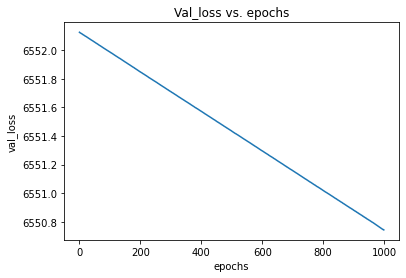

In [114]:
loss5 = []
for value in history5:
    loss5.append(value['val_loss'])
plt.plot(loss5)
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.title('Val_loss vs. epochs')

In [124]:
epochs = 10000
lr = 1e-6
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6550.7148
Epoch [40], val_loss: 6550.6875
Epoch [60], val_loss: 6550.6592
Epoch [80], val_loss: 6550.6304
Epoch [100], val_loss: 6550.6025
Epoch [120], val_loss: 6550.5742
Epoch [140], val_loss: 6550.5459
Epoch [160], val_loss: 6550.5171
Epoch [180], val_loss: 6550.4893
Epoch [200], val_loss: 6550.4604
Epoch [220], val_loss: 6550.4321
Epoch [240], val_loss: 6550.4033
Epoch [260], val_loss: 6550.3750
Epoch [280], val_loss: 6550.3472
Epoch [300], val_loss: 6550.3193
Epoch [320], val_loss: 6550.2910
Epoch [340], val_loss: 6550.2627
Epoch [360], val_loss: 6550.2344
Epoch [380], val_loss: 6550.2065
Epoch [400], val_loss: 6550.1782
Epoch [420], val_loss: 6550.1504
Epoch [440], val_loss: 6550.1211
Epoch [460], val_loss: 6550.0938
Epoch [480], val_loss: 6550.0654
Epoch [500], val_loss: 6550.0376
Epoch [520], val_loss: 6550.0078
Epoch [540], val_loss: 6549.9800
Epoch [560], val_loss: 6549.9517
Epoch [580], val_loss: 6549.9233
Epoch [600], val_loss: 6549.8945
Epoch [620], v

Text(0.5, 1.0, 'Val_loss vs. epochs')

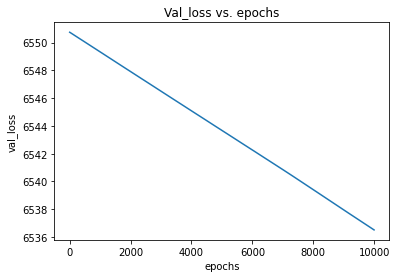

In [126]:
loss6 = []
for value in history5:
    loss6.append(value['val_loss'])
plt.plot(loss6)
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.title('Val_loss vs. epochs')

**Q: What is the final validation loss of your model?**

In [127]:
val_loss = evaluate(model, val_loader)
val_loss

{'val_loss': 6536.51025390625}

Let's log the final validation loss to Jovian and commit the notebook

In [128]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [129]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/rajibdasbhagat/02-insurance-linear-regression


'https://jovian.ai/rajibdasbhagat/02-insurance-linear-regression'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [130]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [135]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([41.0000,  1.0000, 21.1266,  1.0000,  0.0000])
Target: tensor([6648.8257])
Prediction: tensor([8784.3086])


In [136]:
input, target = val_ds[20]
predict_single(input, target, model)

Input: tensor([19.0000,  0.0000, 29.1194,  0.0000,  1.0000])
Target: tensor([35306.0039])
Prediction: tensor([4096.1963])


In [137]:
input, target = val_ds[30]
predict_single(input, target, model)

Input: tensor([19.0000,  0.0000, 31.1467,  0.0000,  0.0000])
Target: tensor([2258.5164])
Prediction: tensor([4090.2588])


In [143]:
for i in range(10):
    input, target = val_ds[i]
    predict_single(input, target, model)
    print("---------------------------")

Input: tensor([61.0000,  0.0000, 32.3301,  4.0000,  0.0000])
Target: tensor([38775.0977])
Prediction: tensor([13087.6035])
---------------------------
Input: tensor([23.0000,  1.0000, 35.9870,  3.0000,  0.0000])
Target: tensor([3813.4517])
Prediction: tensor([4967.9902])
---------------------------
Input: tensor([18.0000,  1.0000, 33.0770,  0.0000,  0.0000])
Target: tensor([1205.2317])
Prediction: tensor([3877.9246])
---------------------------
Input: tensor([34.0000,  0.0000, 18.4300,  3.0000,  0.0000])
Target: tensor([7158.2202])
Prediction: tensor([7299.8726])
---------------------------
Input: tensor([41.0000,  1.0000, 23.2218,  1.0000,  0.0000])
Target: tensor([7269.9883])
Prediction: tensor([8786.4961])
---------------------------
Input: tensor([56.0000,  1.0000, 31.1467,  1.0000,  0.0000])
Target: tensor([12468.7812])
Prediction: tensor([11998.5781])
---------------------------
Input: tensor([60.0000,  1.0000, 23.5904,  1.0000,  0.0000])
Target: tensor([13899.3613])
Prediction: 

Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset
Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

In [151]:
print(help(jovian))
dir(jovian)

Help on package jovian:

NAME
    jovian

PACKAGE CONTENTS
    __main__
    _flavor
    _version
    callbacks (package)
    utils (package)

VERSION
    0.2.26

FILE
    /usr/local/lib/python3.6/dist-packages/jovian/__init__.py


None


['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_flavor',
 '_initialize_jovian',
 '_version',
 'commit',
 'configure',
 'get_records',
 'log_dataset',
 'log_git',
 'log_hyperparams',
 'log_metrics',
 'notify',
 'reset',
 'reset_config',
 'submit',
 'utils',
 'version']

In [145]:
print(jovian.get_records())

[('7fd47699d1ac4b829b8c1f47f3877bd8', 'metrics', {'val_loss': {'val_loss': 7263.2646484375}}), ('4d843de4072e4339b01994a73b9474ee', 'metrics', {'val_loss': {'val_loss': 6550.7431640625}}), ('2f95c815790b4bc38dd6df18eaca71e7', 'metrics', {'val_loss': {'val_loss': 6536.51025390625}})]


In [ ]:
jovian.commit(project=project_name)